In [1]:
# TODO descriptions...

In [36]:
import os
import datetime

import tensorflow as tf
from matplotlib import pyplot as plt
from utils.image_data_set_loader import get_zipped_images

from utils.image_transformation import random_jitter, normalize, resize
from utils.model_utils import u_net_generator, discriminator, plot_transformations, create_training_function, \
    get_instance_data_set_generator, plot_transformation

In [3]:
# settings for training
epochs = 300
plot_each_nth_epoch = 5

In [4]:
# create directory for logs
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [5]:
# create directory for plots and models
output_base_dir = "./output"
os.makedirs(output_base_dir, exist_ok=True)
os.makedirs(output_base_dir+"/train", exist_ok=True)
os.makedirs(output_base_dir+"/model", exist_ok=True)

In [41]:
# get samples of images with Afremovs' paintings
paintings = get_zipped_images('afremov.zip','http://janmaly.name/data_sets/photo2painting/afremov.zip')

# get samples of images with photos
photos_activities = get_zipped_images('photos_activities.zip','http://janmaly.name/data_sets/photo2painting/photos_activities.zip')

2588672/2582421 [==============================] - 3s 1us/step

In [42]:
# do the train/test split

# split for paintings
paintings_train = paintings[:-5]
paintings_test = paintings[-5:]

# split for photos
photos_train = photos_activities[:-10]
photos_test = photos_activities[-10:]

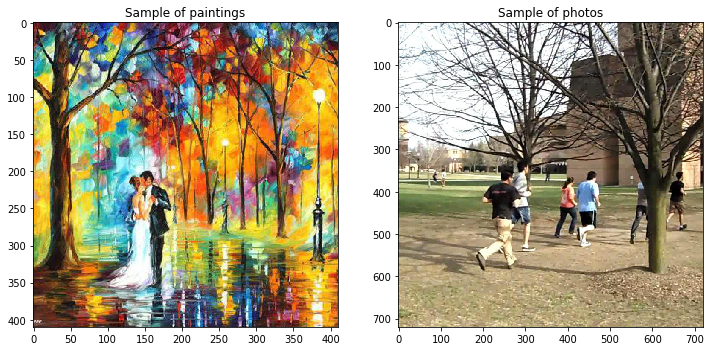

In [43]:
# show a sample per domain

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.title('Sample of paintings')
plt.imshow(normalize(paintings_train[0]) * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sample of photos')
plt.imshow(normalize(photos_train[0]) * 0.5 + 0.5)

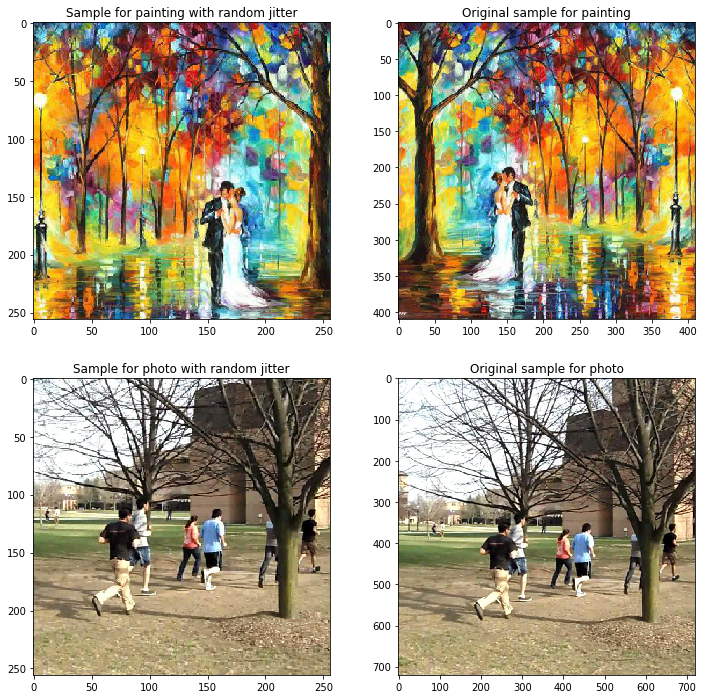

In [40]:
# show a sample per domain with applied random jitter

new_painting = normalize(random_jitter(paintings_train[0], target_size=(256, 256), mirror=True))
new_photo = normalize(random_jitter(photos_train[0], target_size=(256, 256), mirror=True))

plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.title('Sample for painting with random jitter')
plt.imshow(new_painting * 0.5 + 0.5)

plt.subplot(222)
plt.title('Original sample for painting')
plt.imshow(normalize(paintings_train[0]) * 0.5 + 0.5)

plt.subplot(223)
plt.title('Sample for photo with random jitter')
plt.imshow(new_photo * 0.5 + 0.5)

plt.subplot(224)
plt.title('Original sample for photo')
plt.imshow(normalize(photos_train[0]) * 0.5 + 0.5)

In [10]:
# define architecture of networks and initialize networks... keep all values to default

# how many output channels to have
output_channels = 3

# initialize generators
generator_x2y = u_net_generator(output_channels=output_channels)
generator_y2x = u_net_generator(output_channels=output_channels)

# initialize discriminators
discriminator_x = discriminator()
discriminator_y = discriminator()

In [11]:
# get data set generators

# define function to apply on each data sample
function_to_apply_per_train_instance=lambda image: \
    tf.cast([normalize(random_jitter(image, target_size=(256, 256), mirror=True))], tf.float32)
function_to_apply_per_test_instance=lambda image: tf.cast([normalize(resize(image, size=(256, 256)))], tf.float32)

data_set_generator_x_train = get_instance_data_set_generator(paintings_train, function_to_apply_per_train_instance)
data_set_generator_x_test = get_instance_data_set_generator(paintings_test, function_to_apply_per_test_instance)
data_set_generator_y_train = get_instance_data_set_generator(photos_train, function_to_apply_per_train_instance)
data_set_generator_y_test = get_instance_data_set_generator(photos_test, function_to_apply_per_test_instance)

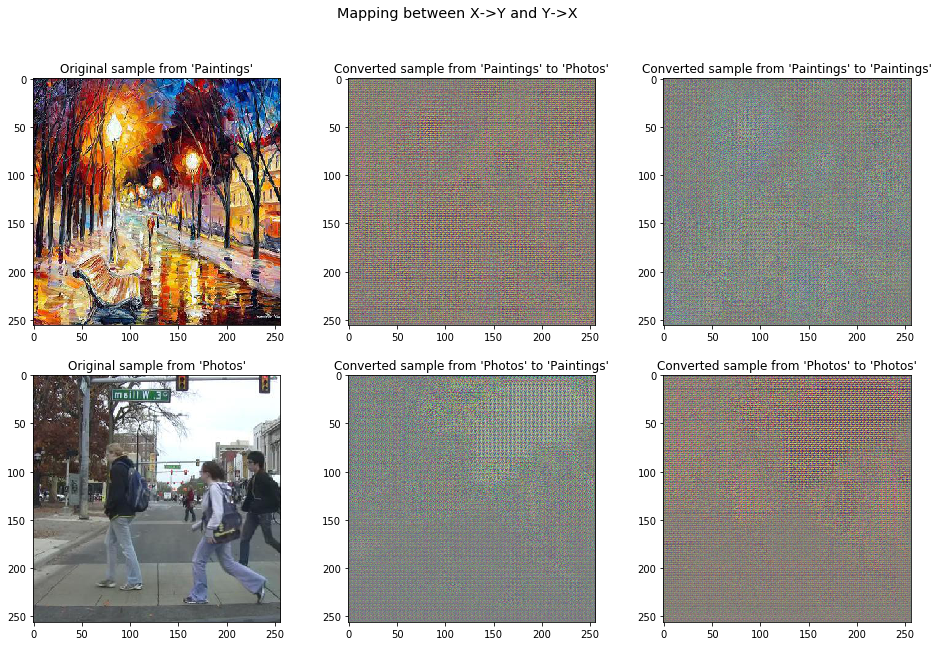

In [12]:
# plot transformations (before training)
plot_transformations(new_painting, new_photo, generator_x2y, generator_y2x, distributions_names=('Paintings', 'Photos'),
                     fig_size=(16, 10))

In [13]:
# compute instances to use per batch
instances_per_batch = min(len(paintings_train), len(photos_train))

# compute instances to use per batch
instances_in_test_set = min(len(paintings_test), len(photos_test))

In [14]:
# init. summary writer
summary_writer = tf.summary.create_file_writer(logs_base_dir + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# init. training epoch executor
training_epoch_executor = create_training_function(data_set_generator_x_train, data_set_generator_y_train, 
                                                   instances_per_batch, generator_x2y, discriminator_x, generator_y2x, 
                                                   discriminator_y, summary_writer=summary_writer)

In [ ]:
# run training for N number of epochs

sum_time = 0

for i in range(epochs):
    epoch, tm = next(training_epoch_executor)
    sum_time = sum_time + tm
    if (epoch + 1) % plot_each_nth_epoch == 0:
        # plot the most recent results
        plot_title = "Generated data in iteration {}. Average time per epoch was {}s."\
            .format(epoch+1, sum_time / plot_each_nth_epoch)
        save_as = "{}/{}/{}_epoch.jpg".format(output_base_dir, "train", epoch+1)
        plot_transformations(next(data_set_generator_x_test)[0], next(data_set_generator_y_test)[0], generator_x2y, 
                             generator_y2x, distributions_names=('Paintings', 'Photos'), main_title=plot_title, 
                             save_as=save_as, fig_size=(16, 10))
        # reset timer
        sum_time = 0

In [ ]:
# save the weights
generator_x2y.save_weights('./output/model/generator_x2y/my_checkpoint')
generator_y2x.save_weights('./output/model/generator_y2x/my_checkpoint')
discriminator_x.save_weights('./output/model/discriminator_x/my_checkpoint')
discriminator_y.save_weights('./output/model/discriminator_y/my_checkpoint')

In [ ]:
# plot transformations (after training)

for i in range(instances_in_test_set):
    x_instance = next(data_set_generator_x_test)[0]
    y_instance = next(data_set_generator_y_test)[0]
    save_as = "{}/{}_instance.jpg".format(output_base_dir, i)
    plot_transformations(x_instance, y_instance, generator_x2y, generator_y2x, 
                         distributions_names=('Paintings', 'Photos'), fig_size=(16, 10), save_as=save_as)

In [51]:
# plot transformations for photos only

# definition of a function to apply per image
function_to_apply_per_instance=lambda image: normalize(resize(image, size=(256, 256)))

# plot paintings in the train set
for i, img in enumerate(photos_train):
    save_as = "{}/train_{}_photo_transformation.jpg".format(output_base_dir, i)
    plot_transformation(function_to_apply_per_instance(img), generator_y2x, save_as=save_as, 
                        sample_distribution_name='Photo', other_distribution_name='Painting')

# plot paintings in the train set
for i, img in enumerate(photos_test):
    save_as = "{}/test_{}_photo_transformation.jpg".format(output_base_dir, i)
    plot_transformation(function_to_apply_per_instance(img), generator_y2x, save_as=save_as, 
                        sample_distribution_name='Photo', other_distribution_name='Painting')